In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('white')
sns.set_theme('paper')

from sklearn.metrics import confusion_matrix, accuracy_score, pairwise
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn import svm
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import string
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def clean_strings(x):
    stop = stopwords.words('english')
    x_punc_l = x.apply(lambda z: z.lower().translate(str.maketrans('', '', string.punctuation)))
    x_punc_l_stop = x_punc_l.apply(lambda z: ' '.join([word.lower() for word in z.split() if word not in (stop)]))
    x_final = x_punc_l_stop.apply(lambda z: ' '.join([lemmatizer.lemmatize(word) for word in z.split()])).str.findall(
        "\w{3,}").str.join(" ")
    return x_final


def extract_bag_of_words_train_test(dataset_train, dataset_test):
    train = pd.read_csv(dataset_train)
    test = pd.read_csv(dataset_test)

    x_train_matrix = train['review']
    x_test_matrix = test['review']
    y_train = [1 if x == 'positive' else -1 for x in train['sentiment']]
    y_test = [1 if x == 'positive' else -1 for x in test['sentiment']]

    return x_train_matrix, y_train, x_test_matrix, y_test


X_train, y_train, X_test, y_test = extract_bag_of_words_train_test("movie_review_train.csv",
                                                                                 "movie_review_test.csv")
print(len(X_train))
print(len(y_train))

5000
5000


In [ ]:
class SVMClassifier:
    '''Support Vector Machine classifier.'''

    def __init__(self, kernel='custom', a=2, b=3.6667):
        '''Initialise kernel and pipeline etc.'''
        self.a = a
        self.b = b
        if kernel == "rbf":
            self.clf = svm.SVC(kernel=kernel)
            self.params = {
                "C": np.linspace(1.5, 2, 3),
                "gamma": ['scale'],
                'shrinking': [True]
            }
        elif kernel == "custom":
            self.kernel = self.my_kernel
            self.params = {"C": np.linspace(0.1, 4, 3)}
            self.clf = svm.SVC(kernel=self.kernel)

        # Instantiate the model
        elif kernel == "linear":
            self.clf = svm.LinearSVC()
            self.params = {
                "C": np.linspace(1, 1.6, 3),
                "loss": ['hinge'],
                'penalty': ['l2']
            }
        else:
            self.clf = svm.SVC(kernel=kernel)

        # Create Pipeline
        self.pipe = Pipeline([
            ('tfid', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
            ('clf', GridSearchCV(self.clf, param_grid=self.params, cv=5, n_jobs=-1, verbose=4))
        ])

    def my_kernel(self, x, x_):
        return np.log(self.a * np.dot(x, x_.T) + self.b * np.ones(np.shape(np.dot(x, x_.T))))

    def fit(self, X, y):
        '''Fit the Classifier.'''
        self.pipe.fit(X, y)
        print(self.pipe['clf'].best_params_)
        return

    def predict(self, X):
        '''Make predictions'''
        y = self.pipe.predict(X)
        # accuracy = metrics.accuracy_score(y_test, y)
        # precisions, recall, f1_score, _ = metrics.precision_recall_fscore_support(y_test, y)
        return y

## Linear kernel

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 1.4000000000000001, 'loss': 'hinge', 'penalty': 'l2'}
Accuracy: 0.8986666666666666


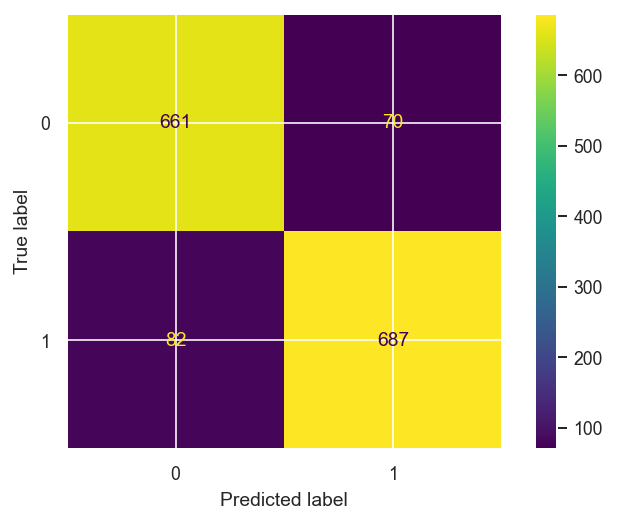

In [ ]:
kernel_choice = 'linear'
X_train, Y_train, X_test, Y_test = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
sc = SVMClassifier(kernel = kernel_choice)
sc.fit(X_train, Y_train)
Y_Pred = sc.predict(X_test)
acc = accuracy_score(Y_test, Y_Pred)
print("Accuracy:",acc)

cm = confusion_matrix(Y_test, Y_Pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## RBF kernel

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 1.8333333333333335, 'gamma': 'scale', 'shrinking': True}
Accuracy: 0.8873333333333333


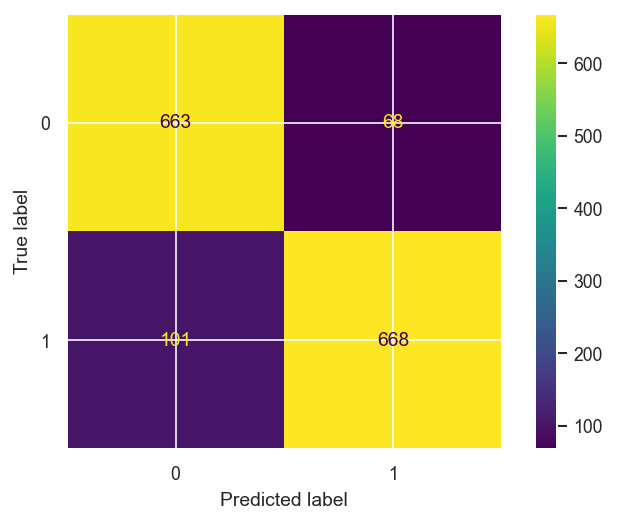

In [ ]:
kernel_choice = 'rbf'

X_train, Y_train, X_test, Y_test = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
sc = SVMClassifier(kernel=kernel_choice)
sc.fit(X_train, Y_train)
Y_Pred = sc.predict(X_test)
acc = accuracy_score(Y_test, Y_Pred)
print("Accuracy:",acc)

cm = confusion_matrix(Y_test, Y_Pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Custom kernel

In [ ]:
kernel_choice = 'custom'

X_train, Y_train, X_test, Y_test = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
for a in np.linspace(1,2.5,4):
    for b in np.linspace(3,4.5,4):
        sc = SVMClassifier(a=a, b=b, kernel=kernel_choice)
        sc.fit(X_train, Y_train)
        Y_Pred = sc.predict(X_test)
        acc = accuracy_score(Y_test, Y_Pred)
        print(f"{a}, {b}, Accuracy: {acc}",)
# Best accuracy found to be 2.2, 5
sc = SVMClassifier(a=a, b=b)
sc.fit(X_train, Y_train)
Y_Pred = sc.predict(X_test)
acc = accuracy_score(Y_test, Y_Pred)
print(f"Accuracy: {acc}",)
cm = confusion_matrix(Y_test, Y_Pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Final SVM results

In [ ]:
def test_func_svm(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score 
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    sc = SVMClassifier()
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:",acc)
    return acc
acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")
print(acc)

# Boosting 

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator

class BoostingClassifier(BaseEstimator):
    """Implements the Ensemble Decision Tree Classifier for text"""
    def __init__(self, num_estimators=1000, max_depth=1):
        self.alphas = []
        self.models = []
        self.num_estimators = num_estimators
        self.max_depth = max_depth
        self.pipe = Pipeline([
            ('tfid', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)),
        ])
        
    def fit(self, X, y):
        """Fit the Ensemble Trees"""
        def compute_error(y, y_p, w):
            return (sum(w * (np.not_equal(y, y_p)).astype(int)))/sum(w)
        def compute_alpha(error):
            return np.log((1 - error) / error)
        def update_weights(w, alph, y, y_p):
            return w * np.exp(alph * (np.not_equal(y, y_p)).astype(int))
        
        current_weights = np.ones(len(y)) * 1 / len(y)
        # Fit the tfidf
        X = self.pipe['tfid'].fit_transform(X, y)
        for est in range(0, self.num_estimators):
            model = DecisionTreeClassifier(max_depth=self.max_depth)
            # Add the model to the pipe
            self.pipe.steps.append(['clf', model])
            # Fit the model
            self.pipe['clf'].fit(X, y, sample_weight = current_weights)
            y_pred = self.pipe['clf'].predict(X)
            # Save the fitted classifier
            self.models.append(self.pipe['clf'])
            # Remove the classifier fromt the pipe
            self.pipe.steps.pop(-1)
            # Compute the errors/alphas
            error_model = compute_error(y, y_pred, current_weights)
            alpha_model = compute_alpha(error_model)
            # Save the alphas
            self.alphas.append(alpha_model)
            # Update the weights
            current_weights = update_weights(current_weights, alpha_model, y, y_pred)

    def predict(self, X):
        """Make Predictions"""
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.num_estimators))
        # Transform the test set
        tfidf = self.pipe['tfid']
        X = tfidf.transform(X)
        for est in range(self.num_estimators):
            y_pred_weak = self.models[est].predict(X) * self.alphas[est]
            weak_preds.iloc[:,est] = y_pred_weak

        final_y_pred = np.sign(weak_preds.T.sum()).astype(int)
        return final_y_pred
        
    def plot(self, X, y):
        """Plot the tfidf space. Called before fitting the model."""
        tfidf = self.pipe['tfid'].fit(X)
        X = tfidf.transform(X)
        pca = TruncatedSVD(n_components=2).fit(X)
        XY = pca.transform(X)
        fig, ax = plt.subplots(figsize=(10,10))
        plt.scatter(XY[:,0], XY[:,1], c=y, cmap='viridis')
        plt.show()              


In [ ]:
X_train, Y_train, X_test, Y_test = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
# Initial testing was {'num_estimators':[100, 200, 300, 500, 700, 800, 900, 1000, 1200, 1500], 'max_depth':[1, 2, 3, 4, 5], 'max_features' : [None, 'squared']} 
# However this was too long for runtime limit
bc = BoostingClassifier()
bc = GridSearchCV(bc, param_grid={'num_estimators':[1000], 'max_depth':[1]}, cv=5, n_jobs=-1, scoring='accuracy', verbose=3)
bc.fit(X_train, Y_train)
print(bc.best_params_)
Y_Pred = bc.predict(X_test)
acc = accuracy_score(Y_test, Y_Pred)
print("Accuracy:",acc)

cm = confusion_matrix(Y_test, Y_Pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# DO NOT MODIFY CODE HAS TO WORK WITH THIS
def test_func_boosting(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score    
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    Y_Pred = bc.predict(X_test)    
    acc = accuracy_score(Y_test, Y_Pred)
    return acc
acc = test_func_boosting("movie_review_train.csv", "movie_review_test.csv")
print(acc)